## <font color = 'blue'>Introduction:</font> what is this demo?

The purpose of this demo is to provide a practical demonstration of how to use the PunctaFinder algorithm.

It describes the steps users should take if they want to use PunctaFinder on their own data.

Notably, the demo does **<font color = 'red'>NOT</font>** aim to obtain reliable threshold values for punctum detection, but it does demonstrate how the user _could_ obtain them.

**Bootstrapping** and visualisation of its outcomes are **<font color = 'red'>NOT</font>** included in the demo. How to do this is demonstrated in `PF_Dataset_Creation_and_Threshold_Optimisation.ipynb` 

The demo still provides an opportunity for the user to get some hands-on experience with using PunctaFinder.

Since the provided example data contains 6 cells, the user can analyse these cells to create a validated dataset _(Section 2)_ and/or detect puncta _(Section 4)_.

In _Section 4_ the user can also implement different threshold values and see how this affects punctum detection. 


**The demo contains the following sections:**

**Section 0:** Load the PunctaFinder module

**Section 1:** A look at the example data

**Section 2:** Creating a validated dataset

**Section 3:** Determining optimal threshold values (**<font color = 'red'>no</font>** bootstrapping)

**Section 4:** Using the PunctaFinder and visualising its outputs

## <font color = 'blue'>Section 0:</font> Load the PunctaFinder module

In [ ]:
import punctafinder as PF

## <font color = 'blue'>Section 1:</font> A look at the example data

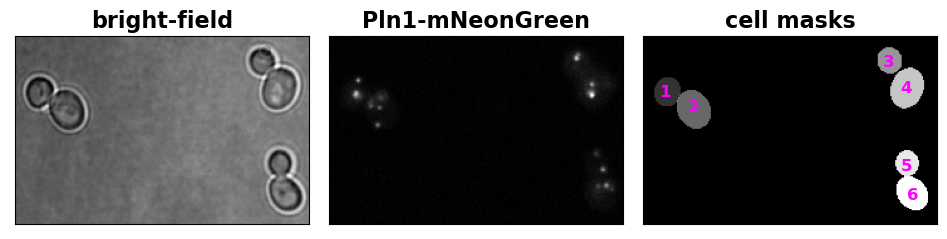

In [11]:
# load demo_data.tif:
demo_data = io.imread('G:/Downloads/demo_data.tif')

# extract the three images from the stack and visualise them
brightfield, GFP, masks = PF.plot_demo_data(demo_data)


The **cell masks** were obtained with BudJ applied to the bright-field image. 

As indicated in the image, each cell mask has its own unique value, _i.e._ all pixels with value 1 belong to cell mask 1, etc.

## <font color = 'blue'>Section 2:</font> Creating a validated dataset

**Note:** in this demo, we use:
- a punctum diameter of 3 pixels;
- an overlap parameter value of 0 (detected puncta cannot overlap).

In [12]:
diameter = 3
overlap = 0

**step 1:** initiate an empty dataframe

In [25]:
df_validated = pd.DataFrame({})

**step 2a:** visually inspect a single cell

_Approach:_ 

- get the cell mask for a single cell (this demo uses **cell 2** from the example data);
- visualise this one cell using `plot_masked_cell`.

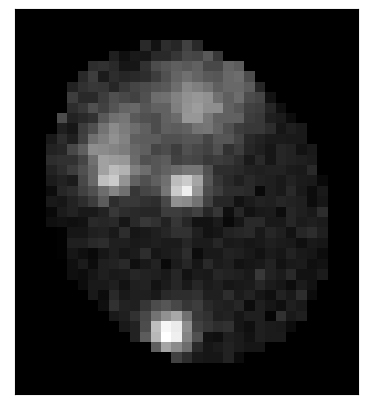

In [26]:
# identifier of the cell you want to study
cell_no = 2
# get cell mask
cell_mask = masks == cell_no # binary image where all px belonging to cell 6 have value True, all others have value False

# visualise the masked cell
PF.plot_masked_cell(GFP, cell_mask)

**step 2b:** determine the number of puncta present

The PunctaFinder can store information on 3 separate categories of puncta.

In this demo, we will make a distinction between:
- **category 1:** the brightest puncta (3 present in example cell 2); 
- **category 2:** dimmer but clear puncta (2 present in example cell 2);
- **category 3:** very dim puncta (1 present in example cell 2).

If you want to use **only 1 category**, simply provide a value of **0** for `N_cat2` and `N_cat3`

In [27]:
N_cat1 = 3
N_cat2 = 2
N_cat3 = 1

**step 3:** run `PF_validated_data` (_i.e._ PunctaFinder function for dataset creation) with these numbers and visualise the outcome with `plot_PF_validated_data`.

_In this visualisation:_

- Puncta belonging to the 3 categories are shown in different colours: **<font color = 'green'>category 1</font>, <font color = 'red'>category 2</font>, <font color = 'blue'>category 3</font>**;
- The number written on each punctum corresponds to the row in the dataframe that describes this punctum; 
- The 5 brightest non-punctate locations (with the highest average fluorescence intensity) are indicated with a white rectangle and the index of their rows in the dataframe.

The written row numbers **(indices)** can be used to make manual changes in the dataframe with validated data (as demonstrated in **step 4**)

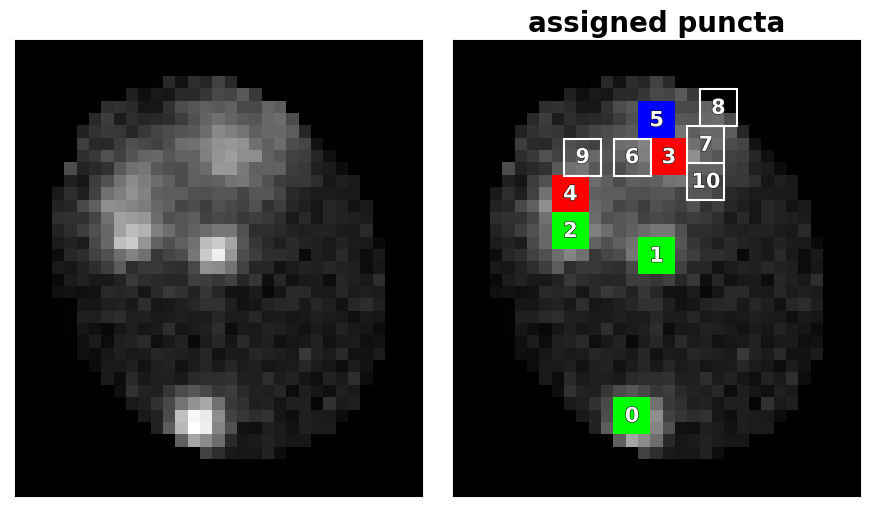

In [28]:
# run PF for dataset creation
df_cell, cropped_cell, mask_cat1, mask_cat2, mask_cat3 = PF.PF_validated_data(GFP, cell_mask, 3, 0, N_cat1, N_cat2, N_cat3)
# visualise the results
PF.plot_PF_validated_data(df_cell, cropped_cell, mask_cat1, mask_cat2, mask_cat3)

**step 4** _(optional)_**:** make manual changes to the dataframe

_In this example:_

- we will change the assigned category 3 spot (index 5) to non-punctate;
- we will change the non-punctate spot at index 8 to category 3.

To do this, use `df.at[index, "state"] = "desired state"` to make manual changes to the dataframe:

In [29]:
df_cell.at[5, "state"] = "nonpunctate"
df_cell.at[8, "state"] = "category 3"

**step 5:** add validated data pertaining to one cell (`df_cell`) to the dataframe with all data (`df_validated`)

In [30]:
df_validated = pd.concat([df_validated, df_cell])

**step 6:** save the dataframe with all validated data

In [31]:
# save the dataframe (once it is complete)
df_validated.to_csv("G:/Downloads/validated_dataset_demo.csv")

## <font color = 'blue'>Section 3:</font> Determining optimal threshold values (<font color = 'red'>no </font> bootstrapping)

**Note:** as stated in the introduction, the demo does not cover bootstrapping or visualisation of its results. 

Relevant code for this purpose is available in the file `PunctaFinder_Code_Dataset_Thresholds.ipynb`.

**step 1:** load the validated dataset

In [32]:
df_validated = pd.read_csv("G:/Downloads/validated_dataset_demo.csv", header = 0, sep = ',')

**step 2:** user decisions for threshold optimisation:

- weighting factor (`FN_weight`) for false negatives within the test statistic according to `test_statistic = #FPs + FN_weight * #FNs`;
- threshold values tested: for each of the three punctum selection criteria, the user sets a minimum value, maximum value and stepsize. 

In [33]:
FN_weight = 0.75

In [55]:
# for each criterion create a list with [min_threshold, max_threshold, stepsize]
T_local_vals = [1.1, 2, 0.05]
T_global_vals = [1.2, 3, 0.05]
T_cv_vals = [0.1, 0.5, 0.05]

# create a suitable input for the threshold optimisation function
potential_thresholds = PF.potential_threshold_values(T_local_vals, T_global_vals, T_cv_vals)

**step 3:** define what you want to detect:

Specifically,
- which locations should satisfy the thresholds? These locations are counted as FN if they don't satisfy the applied thresholds;
- which locations should _not_ satifsfy the thresholds? These locations are counted as FP if they do satisfy the applied thresholds.

In this demo, we will obtain threshold values for _combined_ detection of puncta belonging to category 1 and category 2.

**In practice, this means:** 

locations with `state` category 1 or category 2 should satisfy the detection thresholds, 

while locations with `state` category 3 or nonpunctate should _not_ satisfy the detection thresholds.

In [43]:
should_detect = ['category 1', 'category 2']
should_not_detect = ['category 3', 'nonpunctate']

**step 4:** perform the threshold optimisation _(without bootstrapping)_

In [46]:
T_local, T_global, T_CV = PF.thresholds_all_data(df_validated, FN_weight, potential_thresholds, should_detect, should_not_detect)

OPTIMAL COMBINATION OF THRESHOLD VALUES:
local intensity ratio: 1.3000000000000003
global intensity ratio: 2.3000000000000007
CV: 0.30000000000000004

 0 FPs; 0 FNs


**step 5:** **<font color = 'red'>manually check</font>** that the obtained threshold values are **<font color = 'red'>NOT</font>** equal to a _minimum_ or _maximum_ of tested threshold values.

**<font color = 'blue'>If</font>** this is the case, <font color = 'blue'>**extend**</font> the range of tested values _(step 2)_ and repeat the analysis _(step 4)_.

## <font color = 'blue'>Section 4:</font> Using the PunctaFinder and visualising its outputs

**step 1:** run PunctaFinder (with thresholds optained from optimisation approach)

_Practical steps:_
- select a cell to analyse (in this demo, we choose **example cell 6**);
- get the mask for this cell;
- run PunctaFinder.

In [48]:
# identifier of the cell you want to study
cell_no = 6
# get cell mask
cell_mask = masks == cell_no

# run PF
df, cropped_cell, puncta_mask_set, puncta_mask_variable, puncta_mask_individual = PF.PF_visualisation(GFP, cell_mask, 3, 0, T_local, T_global, T_CV)

**step 2:** visualise PunctaFinder outputs using `plot_PF_visualisation`

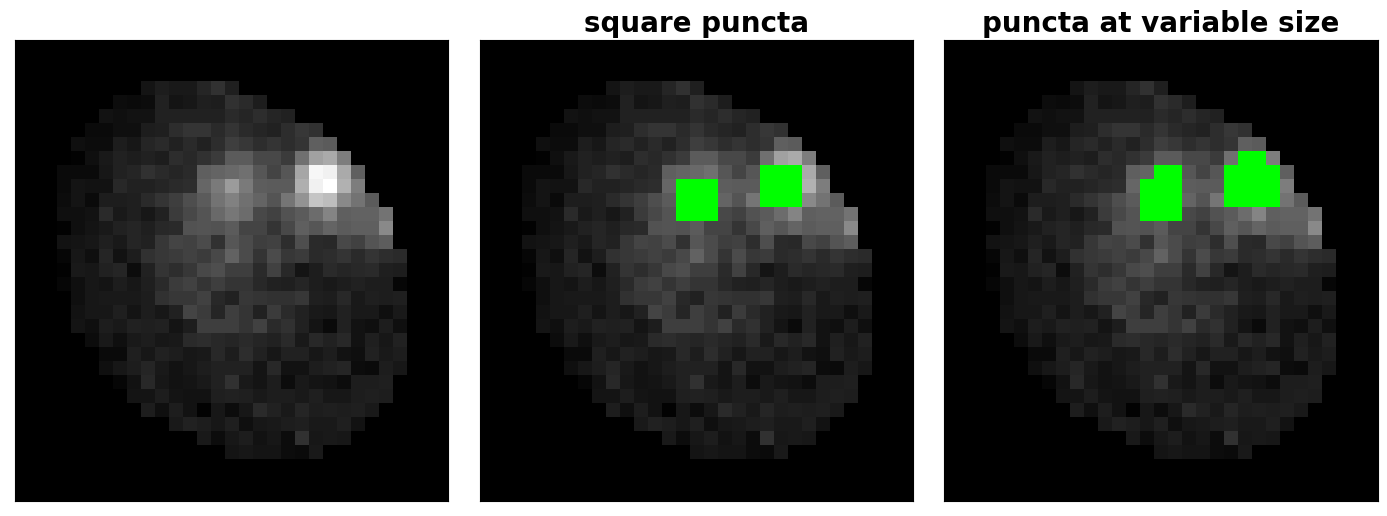

In [54]:
PF.plot_PF_visualisation(cropped_cell, puncta_mask_set, puncta_mask_variable)